Firefighter Cardiorespiratory Fitness Test Analysis


## 1) Data Inspection and Cleaning

In [2]:
# List of libraries required
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import scipy as sp
import scipy.stats as stats
from scipy.stats import ttest_ind
from scipy.stats import t
import statsmodels.formula.api as sm
from statsmodels.graphics.api import influence_plot
from statsmodels.graphics.regressionplots import plot_regress_exog, plot_fit, plot_leverage_resid2, influence_plot
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pingouin as pg
import itertools as it
import math
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Read firefighter fitness test data
#source='https://docs.google.com/spreadsheets/d/1wfA9Wjc69cLdfplR6KU-v7Lq88R1JEHP'

df = pd.read_excel('Master_raw.xlsx', sheet_name='All')


In [4]:
df.head(3)

ID  Pass       AbsVO2     RelVO2  MHR  HRR_2  Total EE  Total SE  Total TT  \
0   1     1  3979.333333  49.233333  207  173.0       320         0       320   
1   2     1  4263.666667  48.433333  191  129.0       105       240       345   
2   3     1  4400.666667  52.966667  201  165.0       420       300       720   

          VCO2          VE         BF       RER  Age  Height    BM  
0  4017.333333  136.666667  46.666667  1.010000   19   184.2  80.8  
1  4074.666667  134.000000  54.333333  0.956667   24   184.3  88.1  
2  4255.333333  163.000000  55.666667  0.966667   21   178.0  83.1

In [5]:
# Renaming columns for ease of use
df.columns = ['ID', 'Pass', 'AbsVO2', 'RelVO2', 'MHR', 'HR_2', 'EE', 'SE', 'TE', 'VCO2', 'VE', 'BF', 'RER', 'Age', 'Height','BM']

In [6]:
# Rearrange columns
df = df[['ID', 'Pass', 'Age', 'Height', 'BM', 'EE', 'SE', 'TE','MHR','HR_2','RelVO2','AbsVO2','VCO2','VE','BF','RER']]

In [7]:
# Check for data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      121 non-null    int64  
 1   Pass    121 non-null    int64  
 2   Age     121 non-null    int64  
 3   Height  121 non-null    float64
 4   BM      121 non-null    float64
 5   EE      121 non-null    int64  
 6   SE      121 non-null    int64  
 7   TE      121 non-null    int64  
 8   MHR     121 non-null    int64  
 9   HR_2    119 non-null    float64
 10  RelVO2  121 non-null    float64
 11  AbsVO2  121 non-null    float64
 12  VCO2    119 non-null    float64
 13  VE      119 non-null    float64
 14  BF      119 non-null    float64
 15  RER     119 non-null    float64
dtypes: float64(9), int64(7)
memory usage: 15.2 KB


Note: all Dtype are good to go

In [8]:
# Check for duplicates
df.duplicated().any()

False

In [9]:
# Check number of observations and columns
df.shape

(121, 16)

Note: total of 121 observations

In [10]:
# Check for negatives
df.agg(lambda x: sum(x < 0)).sum()

0

In [11]:
# Check for missing values (should be < 10% for each column)
df.isnull().sum()

ID        0
Pass      0
Age       0
Height    0
BM        0
EE        0
SE        0
TE        0
MHR       0
HR_2      2
RelVO2    0
AbsVO2    0
VCO2      2
VE        2
BF        2
RER       2
dtype: int64

In [12]:
# Fill in the missing values in 'HR_2' by replacing with the mean for SG or UG
df['HR_2'].fillna(df.groupby(["Pass"])['HR_2'].transform('mean'), inplace=True)

In [13]:
# Create a column for heart rate recovery (MHR - HR after 2 min of recovery)
df['HRR'] = df['MHR'] - df['HR_2']

In [14]:
# Descriptive analysis for the entire dataset
df.describe()

ID        Pass         Age      Height          BM  \
count  121.000000  121.000000  121.000000  121.000000  121.000000   
mean    61.000000    0.719008   26.338843  178.597521   84.882231   
std     35.073732    0.451352    5.838884    6.232274   10.670276   
min      1.000000    0.000000   18.000000  160.000000   66.450000   
25%     31.000000    0.000000   22.000000  174.000000   78.450000   
50%     61.000000    1.000000   25.000000  178.900000   83.650000   
75%     91.000000    1.000000   29.000000  183.000000   90.150000   
max    121.000000    1.000000   44.000000  194.600000  122.200000   

                EE          SE           TE         MHR        HR_2  \
count   121.000000  121.000000   121.000000  121.000000  121.000000   
mean    206.157025  197.991736   404.148760  195.099174  155.233933   
std     197.731679  170.914964   277.953253    9.316120   15.268926   
min       0.000000    0.000000     0.000000  171.000000  123.000000   
25%      90.000000   30.000000   220.000000  189.000000  145.000000   
50%     150.000000  180.000000   340.000000  195.000000  154.000000   
75%     300.000000  300.000000   580.000000  201.000000  165.000000   
max    1560.000000  720.000000  1680.000000  219.000000  193.000000   

           RelVO2       AbsVO2         VCO2          VE          BF  \
count  121.000000   121.000000   119.000000  119.000000  119.000000   
mean    46.514304  3928.231163  3802.090629  129.776547   50.191630   
std      6.425268   590.771509   573.918142   19.709578    8.140828   
min     30.733333  2632.700000  2441.800000   80.666667   29.666667   
25%     41.833333  3479.000000  3415.916667  116.666667   44.666667   
50%     46.600000  3870.333333  3749.000000  129.333333   50.333333   
75%     50.500000  4347.500000  4161.666667  141.833333   55.166667   
max     61.650000  6006.000000  5781.333333  194.333333   74.000000   

              RER         HRR  
count  119.000000  121.000000  
mean     0.976299   39.865241  
std      0.039426   11.494198  
min      0.823333    0.000000  
25%      0.955000   34.000000  
50%      0.976667   40.000000  
75%      1.003333   48.000000  
max      1.080952   69.000000

Note: there is a problem with HRR because values should be >= 20 bpm (difference between MHR and HR after 2 min of recovery). The problem probably comes from a wrong value of HR_2 entered. 

In [15]:
# Check MHR and HR_2 associated with low values of HRR
df.sort_values('HRR', ascending=True)[['HRR','HR_2','Pass']].head()

HRR   HR_2  Pass
3     0.0  192.0     1
64    6.0  176.0     1
19   12.0  181.0     0
101  15.0  193.0     1
111  16.0  189.0     1

Note: ID #3 and #64 are considered wrong values of HR_2 entered because if applicants would not have recovered faster than 10 bpm in 2 min, an intervention would have been necessary and this did not happen. The MHR value was automatically detected by the metabolic system during the test but the HR_2 was manually recorded by the exercise physiologist assistant. Consequently, I suspect that the assistant miscalculated the HR_2 and the values should be replaced by the mean value of HR_2 (from SG) for these 2 observations. 

In [16]:
# Replace the miscalculated HR_2 for ID #3 & #64 with the mean from SG
df.loc[3, 'HR_2'] = df[df['Pass']==1]['HR_2'].mean()
df.loc[64, 'HR_2'] = df[df['Pass']==1]['HR_2'].mean()

# Recalculate HRR
df['HRR'] = df['MHR'] - df['HR_2']

# Re-check HRR values
df.sort_values('HRR', ascending=True)[['HRR']].head()

HRR
19   12.0
101  15.0
111  16.0
48   18.0
8    23.0

## 2) Exploratory Data Analysis (EDA)

In [17]:
# Descriptive analysis per group (SG vs UG)
df.groupby('Pass').aggregate(['mean','std','min','max'])[['Age', 'Height', 'BM', 'EE', 'SE', 'TE','MHR','HRR','RelVO2','AbsVO2','VCO2','VE','BF','RER']].T

Pass                   0            1
Age    mean    28.411765    25.528736
       std      7.435043     4.898598
       min     20.000000    18.000000
       max     44.000000    39.000000
Height mean   179.176471   178.371264
       std      7.853008     5.508976
       min    160.200000   160.000000
       max    194.600000   190.100000
BM     mean    90.354412    82.743678
       std     13.717261     8.378529
       min     66.850000    66.450000
       max    122.200000   105.200000
EE     mean   141.470588   231.436782
       std    118.331388   216.520996
       min      0.000000     0.000000
       max    460.000000  1560.000000
SE     mean   156.323529   214.275862
       std    150.359714   176.439705
       min      0.000000     0.000000
       max    480.000000   720.000000
TE     mean   297.794118   445.712644
       std    216.158581   289.228521
       min      0.000000     0.000000
       max    920.000000  1680.000000
MHR    mean   194.588235   195.298851
       std      9.875337     9.139888
       min    171.000000   174.000000
       max    213.000000   219.000000
HRR    mean    36.588235    41.837049
       std     10.087849    10.339881
       min     12.000000    15.000000
       max     61.000000    69.000000
RelVO2 mean    38.687233    49.573159
       std      2.785866     4.576236
       min     30.733333    43.000000
       max     42.066667    61.650000
AbsVO2 mean  3491.315133  4098.979957
       std    454.767419   550.153526
       min   2632.700000  3060.000000
       max   4593.666667  6006.000000
VCO2   mean  3362.167592  3970.898306
       std    431.708000   532.098604
       min   2441.800000  2859.000000
       max   4158.000000  5781.333333
VE     mean   116.277359   134.956467
       std     18.165598    17.808944
       min     80.666667   105.000000
       max    146.092857   194.333333
BF     mean    47.701355    51.147200
       std      8.356908     7.898052
       min     29.666667    35.333333
       max     64.800000    74.000000
RER    mean     0.973815     0.977252
       std      0.048205     0.035773
       min      0.823333     0.883333
       max      1.080952     1.060000

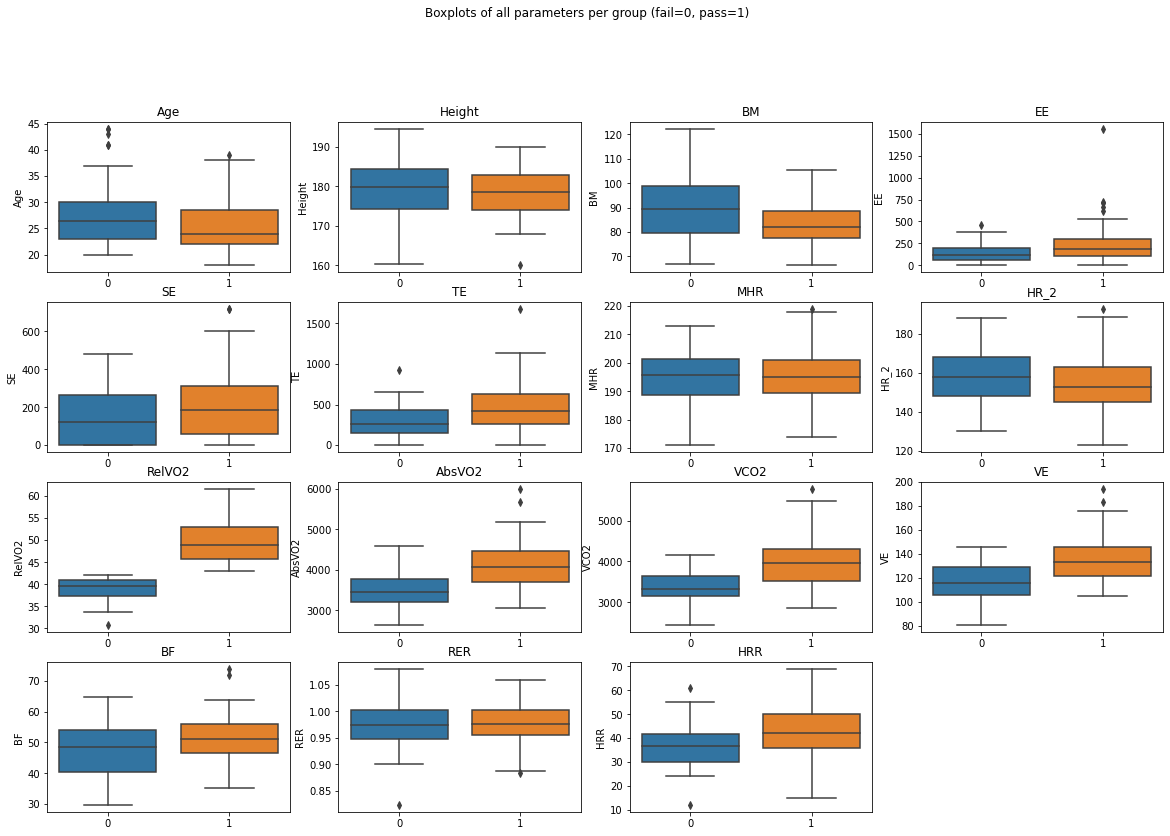

In [18]:
# Boxplot to visually identify potential outliers
fig = plt.figure(figsize=(20,16))
plt_count = 1

for col in df.columns[2:]:
    plt.subplot(5,4,plt_count)
    plt.title(col)
    sns.boxplot(x='Pass', y=col, data=df);
    plt.xlabel('')
    plt_count += 1
    
plt.suptitle('Boxplots of all parameters per group (fail=0, pass=1)')
plt.show()

Note: according to boxplot, there are potential outliers in all variables. A second method to detect outliers should be used. 

In [19]:
# Check outliers by converting values into z-score where ± 3 std away is considered an outlier
df_z = df.apply(lambda x: stats.zscore(x))
outliers = df_z.stack()[(df_z.stack() > 3) | (df_z.stack() < -3)].unstack()
outliers

SE        BM       Age    AbsVO2        EE        TE
23   3.066898       NaN       NaN       NaN       NaN       NaN
50        NaN  3.511900       NaN       NaN       NaN       NaN
67        NaN       NaN  3.037326       NaN       NaN       NaN
76        NaN       NaN  3.037326       NaN       NaN       NaN
88        NaN       NaN       NaN  3.531667       NaN       NaN
91        NaN  3.271924       NaN       NaN       NaN       NaN
93   3.066898       NaN       NaN       NaN       NaN       NaN
101       NaN       NaN       NaN       NaN  6.875339  4.609251

In [20]:
# Determine values for the outliers for EE/SE/TE
SE_23 = df.iloc[23]['SE']
SE_93 = df.iloc[93]['SE']
EE_101 = df.iloc[101]['EE']
TE_101 = df.iloc[101]['TE']

print('Extreme value for SE is {} h/wk'.format(SE_23/60))
print('Extreme value for SE is {} h/wk'.format(SE_93/60))
print('Extreme value for EE is {} h/wk'.format(EE_101/60))
print('Extreme value for TE is {} h/wk'.format(TE_101/60))

Extreme value for SE is 12.0 h/wk
Extreme value for SE is 12.0 h/wk
Extreme value for EE is 26.0 h/wk
Extreme value for TE is 28.0 h/wk


Notes:
- after looking into BM at index 50 & 91, they are possible values and should not be deleted
- after looking into Age at index 76, it is a possible value and should not be deleted
- after looking into AbsVO2/VCO2/VE at index 88, they are possible values and should not be deleted
- after looking into RER at index 104, it is a possible value and should not be deleted
- after looking into SE at index 23 & 93, it is not realistic for this population to do weight training for 12h/wk on a regular basis and as a result these extreme values are outliers and should be dropped
- after looking into EE at index 101 (z=6.9), it is not realistic for this population to do endurance exercise for 26h/wk on a regular basis and as a result this extreme value is an outlier and should be dropped
- after looking into TE at index 101 (z=4.6), it is not realistic for this population to exercise for a total of for 28h/wk on a regular basis and as a result this extreme value is an outlier and should be dropped

In [21]:
# Remove identified outliers for SE, EE, and TE
'''Note that TE should also be removed when SE is dropped because otherwise TE would only include EE which is not accurate.'''
df.loc[23, ['SE','TE']] = None
df.loc[93, ['SE','TE']] = None
df.loc[101,['EE', 'TE']] = None

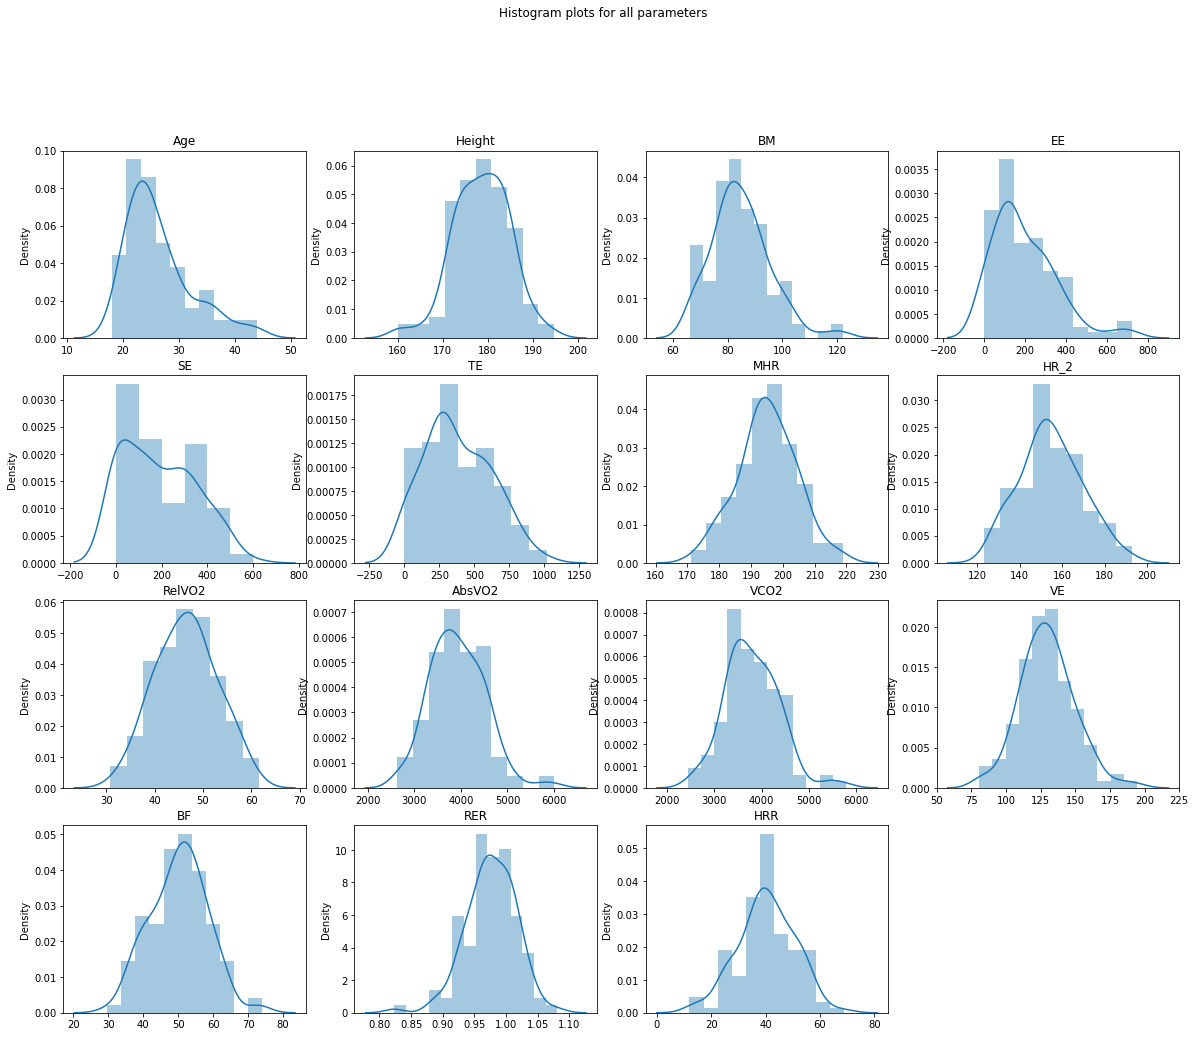

In [22]:
# Plot histograms to look at the distribution for each parameter
count=1
plt.subplots(figsize=(20, 20))

for column in df.columns[2:]:
    plt.subplot(5,4,count)         
    sns.distplot(x=df[column], hist=True, kde=True)
    plt.title(column)
    count+=1

plt.suptitle('Histogram plots for all parameters')
plt.show()

Note: most of the parameters look normally distributed but they should be assessed further before conducting t-test. 

In [23]:
# Split the TE variable into bins of 2h interval
df['TE_hrs'] = pd.cut(df['TE'], 
                      bins=[0, 119, 239, 359, 479, 599, 1700], include_lowest = True,
                      labels=['<2','2-3.9','4-5.9','6-7.9','8-9.9','>=10'])

In [24]:
# Descriptive analysis per group after changes made
df.groupby('Pass').aggregate(['mean','std','min','max'])[['Age', 'Height', 'BM', 'EE', 'SE', 'TE','MHR','HRR','RelVO2','AbsVO2','VCO2','VE','BF','RER']].T

Pass                   0            1
Age    mean    28.411765    25.528736
       std      7.435043     4.898598
       min     20.000000    18.000000
       max     44.000000    39.000000
Height mean   179.176471   178.371264
       std      7.853008     5.508976
       min    160.200000   160.000000
       max    194.600000   190.100000
BM     mean    90.354412    82.743678
       std     13.717261     8.378529
       min     66.850000    66.450000
       max    122.200000   105.200000
EE     mean   141.470588   215.988372
       std    118.331388   162.560070
       min      0.000000     0.000000
       max    460.000000   720.000000
SE     mean   156.323529   202.376471
       std    150.359714   160.123239
       min      0.000000     0.000000
       max    480.000000   600.000000
TE     mean   297.794118   416.630952
       std    216.158581   241.808835
       min      0.000000     0.000000
       max    920.000000  1020.000000
MHR    mean   194.588235   195.298851
       std      9.875337     9.139888
       min    171.000000   174.000000
       max    213.000000   219.000000
HRR    mean    36.588235    41.837049
       std     10.087849    10.339881
       min     12.000000    15.000000
       max     61.000000    69.000000
RelVO2 mean    38.687233    49.573159
       std      2.785866     4.576236
       min     30.733333    43.000000
       max     42.066667    61.650000
AbsVO2 mean  3491.315133  4098.979957
       std    454.767419   550.153526
       min   2632.700000  3060.000000
       max   4593.666667  6006.000000
VCO2   mean  3362.167592  3970.898306
       std    431.708000   532.098604
       min   2441.800000  2859.000000
       max   4158.000000  5781.333333
VE     mean   116.277359   134.956467
       std     18.165598    17.808944
       min     80.666667   105.000000
       max    146.092857   194.333333
BF     mean    47.701355    51.147200
       std      8.356908     7.898052
       min     29.666667    35.333333
       max     64.800000    74.000000
RER    mean     0.973815     0.977252
       std      0.048205     0.035773
       min      0.823333     0.883333
       max      1.080952     1.060000

## 3) Inferential statistics

### a) Check *t* statistic assumptions
    1) data sampled independently 
        ---> data were sampled independently
    2) normally distributed
        ---> use Shapiro-Wilk test
    3) homogeneity of variance 
        ---> use Levene test

**Check assumption #2: normality using Shapiro-Wilk test**

In [25]:
for i in df.columns[2:17]:
  
  # Perform Shapiro-Wilk test
  w,p = stats.shapiro(df[[i]])

  # Determine if p-value is < 0.05
  if p < 0.05:
    print('The sample does NOT come from a normal distribution for {}'.format(i))
  else:
    print('The sample comes from a normal distribution for {}'.format(i))

The sample does NOT come from a normal distribution for Age
The sample comes from a normal distribution for Height
The sample does NOT come from a normal distribution for BM
The sample comes from a normal distribution for EE
The sample comes from a normal distribution for SE
The sample comes from a normal distribution for TE
The sample comes from a normal distribution for MHR
The sample comes from a normal distribution for HR_2
The sample comes from a normal distribution for RelVO2
The sample comes from a normal distribution for AbsVO2
The sample comes from a normal distribution for VCO2
The sample comes from a normal distribution for VE
The sample comes from a normal distribution for BF
The sample comes from a normal distribution for RER
The sample comes from a normal distribution for HRR


Note: according to Shapiro-Wilk test, all parameters are normally distributed except for Age & BM. However, since our sample size > 30 observations, normality was assumed for all parameters.

**Check assumption #3: homogeneity of variance using Levene's test between groups**

In [26]:
# Choose parameters that we want to perform Levene's test
columns_num = ['Age', 'Height', 'BM', 'VCO2', 'VE', 'BF', 'RER', 'EE', 'SE', 'TE', 'MHR', 'HRR', 'RelVO2']

# Create empty DF for Levene's test results
lev_res = pd.DataFrame([])

for var in columns_num:

    # Perform Levene's test  
    lev_df = pg.homoscedasticity(df, dv=var, group='Pass')

    # Add Variable to Levene's test output
    lev_df['Variable'] = var

    # Concat the empty DF with the Levene's test output
    lev_res = pd.concat([lev_res, lev_df])

# Display Levene's test results    
lev_res[['Variable','equal_var']]

Variable  equal_var
levene      Age      False
levene   Height       True
levene       BM      False
levene     VCO2      False
levene       VE      False
levene       BF      False
levene      RER      False
levene       EE      False
levene       SE      False
levene       TE      False
levene      MHR       True
levene      HRR       True
levene   RelVO2      False

Note:
homogeneity of variance is not met for all variables and as a result it violates one assumption to use Student's t-test. The solution is to use Welch's t-test that does not assume homogeneity of variances.

### b) Perform Welch's *t*-test to compare means between SG and UG

Step 1: Create a custom function (welch_ttest) to perform *t*-test with unequal variances and to calculate $ES_{(M1-M2)}$ ± CI

Reference: https://ncss-wpengine.netdna-ssl.com/wp-content/themes/ncss/pdf/Procedures/PASS/Confidence_Intervals_for_the_Difference_Between_Two_Means.pdf

In [27]:
def welch_ttest(x1, x2):

    # Calculate math parameters needed for the formulas
    x1 = x1[x1.notnull()]
    x2 = x2[x2.notnull()]
    n1 = x1.size
    n2 = x2.size
    m1 = np.mean(x1)
    m2 = np.mean(x2)
    v1 = np.var(x1, ddof=1)
    v2 = np.var(x2, ddof=1) 
    se_unpooled = np.sqrt((v1/n1)+(v2/n2)) # SE with unequal variances
    dof_w = ((v1/n1)+(v2/n2))**2 / ((v1**2/(n1**2 *(n1-1))) + (v2**2/(n2**2 *(n2-1)))) # df with unequal variances
        
    # Perform Welch's 2-sided t-test with unequal variances
    t_welch = (m1-m2) / se_unpooled
    '''OR stats.ttest_ind(x_sg, x_ug, nan_policy='omit', equal_var=False)
       OR pg.ttest(x=x_sg, y=x_ug, correction=True)'''
    p = 2*stats.t.cdf(-abs(t_welch), df=dof_w)
    
    # Calculate unstandardized ES(M1-M2)
    delta = m1-m2
    
    # Construct CI for ES(M1-M2)
    '''CI(u1-u2) = (M1-M2) ± t(α/2, df) * SE (unpooled)'''
    crit_t = stats.t.ppf(q=1-(0.05/2), df=dof_w)
    CI_lcl = (m1-m2) - crit_t * se_unpooled 
    CI_ucl = (m1-m2) + crit_t * se_unpooled
          
    # Prepare DF 
    return pd.DataFrame(np.array([t_welch, dof_w, n1, n2, p, delta, CI_lcl, CI_ucl]).reshape(1,-1),
                         columns=['t_welch','df_w', 'n1', 'n2', 'p','M1-M2','95%LCL','95%UCL'])

Step 2: Using the custom function, calculate *t* statistic and $ES_{(M1-M2)}$ ± CI and append to a new DF

In [28]:
# Choose parameters that we want to calculate ES(M1-M2)
columns_num = ['Age', 'Height', 'BM', 'EE', 'SE', 'TE', 'MHR', 'HRR', 'RelVO2', 'AbsVO2', 'VCO2', 'VE', 'BF', 'RER']

# Create an empty DF for t statistic results and ES(M1-M2)
ttest_res = pd.DataFrame([])

# Use the custom function created earlier (def welch_ttest) to calculate t statistic and ES
for var in columns_num:
    x = df[var] # all variables
    x_sg = df[df['Pass']==1][var] # variables in SG
    x_ug = df[df['Pass']==0][var] # variables in UG
    
    # Apply 'def welch_ttest' function
    t_welch = welch_ttest(x_sg, x_ug)

    # Append the results to the empty DF
    ttest_res = ttest_res.append(pd.DataFrame({
         
        # Overall
        'Variable': var,
        'Mean (all)': round(np.mean(x),1),
        'SD (all)': round(np.std(x),1),
        'N (all)': x.count(),
        #'95%LL (all)': round(stats.t.interval(0.95, len(x)-1, loc=np.mean(x), scale=stats.sem(x, nan_policy='omit'))[0],1),
        #'95%UL (all)': round(stats.t.interval(0.95, len(x)-1, loc=np.mean(x), scale=stats.sem(x, nan_policy='omit'))[1],1),
        #'Missing': df[var].isnull().sum(),
        
        # SG - success
        'Mean (SG)': round(np.mean(x_sg),1),
        'SD (SG)': round(np.std(x_sg),1),
        'N_SG': x_sg.count(),
        'N% (SG)': int(x_sg.count()/x.count()*100),
        #'95%LL (SG)': round(stats.t.interval(0.95, len(x_sg)-1, loc=np.mean(x_sg), scale=stats.sem(x_sg, nan_policy='omit'))[0],1),
        #'95%UL (SG)': round(stats.t.interval(0.95, len(x_sg)-1, loc=np.mean(x_sg), scale=stats.sem(x_sg, nan_policy='omit'))[1],1),
                
        # UG - fail
        'Mean (UG)': round(np.mean(x_ug),1),
        'SD (UG)': round(np.std(x_ug),1),
        'N_UG': x_ug.count(),
        'N% (UG)': int(x_ug.count()/x.count()*100),
        #'95%LL (UG)': round(stats.t.interval(0.95, len(x_ug)-1, loc=np.mean(x_ug), scale=stats.sem(x_ug, nan_policy='omit'))[0],1),
        #'95%UL (UG)': round(stats.t.interval(0.95, len(x_ug)-1, loc=np.mean(x_ug), scale=stats.sem(x_ug, nan_policy='omit'))[1],1),
        
        # ES(M1-M2)
        'ES(M1-M2)': round(t_welch['M1-M2'],1),
        '% diff': round(t_welch['M1-M2']/np.mean(x_ug)*100,1),
        '95%LCL': round(t_welch['95%LCL'],1),
        '95%UCL': round(t_welch['95%UCL'],1),
                
        # t statistic
        't statistic': round(t_welch['t_welch'],3),
        'p': round(t_welch['p'],3),
        'df': round(t_welch['df_w'],1),
        
        }, index=[0]), ignore_index=True)

Step 3: Create a summary table from the newly created DF for *t*-test results (ttest_res)

In [29]:
# Format parameters for the summary table
'''Means'''
ttest_res['Mean all (SD)'] = ttest_res['Mean (all)'].astype(str) +' ('+ ttest_res['SD (all)'].astype(str)+')' 
ttest_res['Mean SG (SD)'] = ttest_res['Mean (SG)'].astype(str) +' ('+ ttest_res['SD (SG)'].astype(str)+')' 
ttest_res['Mean UG (SD)'] = ttest_res['Mean (UG)'].astype(str) +' ('+ ttest_res['SD (UG)'].astype(str)+')' 

'''CI for the means'''
#ttest_res['Mean all (95%CI)'] = ttest_res['Mean (all)'].astype(str) +' ('+ ttest_res['95%LCL (all)'].astype(str) +' - '+ ttest_res['95%UCL (all)'].astype(str)+')' 
#ttest_res['Mean UG (95%CI)'] = ttest_res['Mean_UG'].astype(str) +' ('+ ttest_res['95%LCL (UG)'].astype(str) +' - '+ ttest_res['95%UCL (UG)'].astype(str)+')' 
#ttest_res['Mean SG (95%CI)'] = ttest_res['Mean_SG'].astype(str) +' ('+ ttest_res['95%LCL (SG)'].astype(str) +' - '+ ttest_res['95%UCL (SG)'].astype(str)+')' 

'''Sample size'''
ttest_res['N_all'] = ttest_res['N (all)']
ttest_res['N_UG (%)'] = ttest_res['N_UG'].astype(str) +' ('+ ttest_res['N% (UG)'].astype(str) +'%)'
ttest_res['N_SG (%)'] = ttest_res['N_SG'].astype(str) +' ('+ ttest_res['N% (SG)'].astype(str) +'%)'

'''t statistic'''
#ttest_res['p-value'] =  ttest_res['p_raw'].apply(lambda x: '<0.001' if x < 0.001 else str(x)+'**' if x < 0.01 else str(x)+'*' if x < 0.05 else str(x))
ttest_res['p value'] =  ttest_res['p']
ttest_res['ES (M1-M2)'] = ttest_res['ES(M1-M2)']
ttest_res['% diff'] = round(ttest_res['% diff'])

# Create the summary table
summary = ['Variable', 'N_all', 'Mean all (SD)', 'N_SG (%)', 'Mean SG (SD)', 'N_UG (%)', 'Mean UG (SD)',
                'ES (M1-M2)','% diff', '95%LCL', '95%UCL',
                't statistic', 'df', 'p value']

# Display the summary table
ttest_res[summary]

Variable  N_all   Mean all (SD)  N_SG (%)    Mean SG (SD)  N_UG (%)  \
0       Age    121      26.3 (5.8)  87 (71%)      25.5 (4.9)  34 (28%)   
1    Height    121     178.6 (6.2)  87 (71%)     178.4 (5.5)  34 (28%)   
2        BM    121     84.9 (10.6)  87 (71%)      82.7 (8.3)  34 (28%)   
3        EE    120   194.9 (153.9)  86 (71%)   216.0 (161.6)  34 (28%)   
4        SE    119   189.2 (157.5)  85 (71%)   202.4 (159.2)  34 (28%)   
5        TE    118   382.4 (238.9)  84 (71%)   416.6 (240.4)  34 (28%)   
6       MHR    121     195.1 (9.3)  87 (71%)     195.3 (9.1)  34 (28%)   
7       HRR    121     40.4 (10.5)  87 (71%)     41.8 (10.3)  34 (28%)   
8    RelVO2    121      46.5 (6.4)  87 (71%)      49.6 (4.5)  34 (28%)   
9    AbsVO2    121  3928.2 (588.3)  87 (71%)  4099.0 (547.0)  34 (28%)   
10     VCO2    119  3802.1 (571.5)  86 (72%)  3970.9 (529.0)  33 (27%)   
11       VE    119    129.8 (19.6)  86 (72%)    135.0 (17.7)  33 (27%)   
12       BF    119      50.2 (8.1)  86 (72%)      51.1 (7.9)  33 (27%)   
13      RER    119       1.0 (0.0)  86 (72%)       1.0 (0.0)  33 (27%)   

      Mean UG (SD)  ES (M1-M2)  % diff  95%LCL  95%UCL  t statistic    df  \
0       28.4 (7.3)        -2.9   -10.0    -5.7    -0.1       -2.091  44.7   
1      179.2 (7.7)        -0.8    -0.0    -3.8     2.2       -0.548  46.3   
2      90.4 (13.5)        -7.6    -8.0   -12.7    -2.5       -3.022  43.0   
3    141.5 (116.6)        74.5    53.0    21.2   127.9        2.779  82.7   
4    156.3 (148.1)        46.1    30.0   -16.0   108.2        1.481  64.5   
5    297.8 (213.0)       118.8    40.0    28.0   209.6        2.612  68.0   
6      194.6 (9.7)         0.7     0.0    -3.2     4.6        0.363  56.4   
7       36.6 (9.9)         5.2    14.0     1.1     9.4        2.554  61.7   
8       38.7 (2.7)        10.9    28.0     9.5    12.2       15.896  97.6   
9   3491.3 (448.0)       607.7    17.0   412.8   802.6        6.214  72.4   
10  3362.2 (425.1)       608.7    18.0   420.2   797.3        6.438  71.1   
11    116.3 (17.9)        18.7    16.0    11.3    26.1        5.049  57.0   
12      47.7 (8.2)         3.4     7.0     0.1     6.8        2.044  55.3   
13       1.0 (0.0)         0.0     0.0    -0.0     0.0        0.372  46.2   

    p value  
0     0.042  
1     0.587  
2     0.004  
3     0.007  
4     0.143  
5     0.011  
6     0.718  
7     0.013  
8     0.000  
9     0.000  
10    0.000  
11    0.000  
12    0.046  
13    0.711

### c) Calculate standardized $ES_{(d-statistic)}$

Step 1: Create a custom function (d_statistic) to calculate *d* statistic ± CI with unequal variances

*Reference*: Kline, R. B. (2013). Beyond significance testing: Statistics reform in the behavioral sciences (2nd ed.). American Psychological Association.

In [30]:
def d_statistic(x1, x2):

    # Calculate math parameters needed for the formulas
    x1 = x1[x1.notnull()]
    x2 = x2[x2.notnull()]
    n1 = x1.size
    n2 = x2.size
    m1 = np.mean(x1)
    m2 = np.mean(x2)
    v1 = np.var(x1, ddof=1)
    v2 = np.var(x2, ddof=1)
    se_unpooled = np.sqrt((v1/n1)+(v2/n2)) # SE with unequal variances
    dof_w = ((v1/n1)+(v2/n2))**2 / ((v1**2/(n1**2 *(n1-1))) + (v2**2/(n2**2 *(n2-1)))) # df with unequal variances
   
    # Perform Welch's 2-sided t-test with unequal variances
    t_welch = (m1-m2) / se_unpooled
        
    # Calculate d statistic using t-score
    d_w = t_welch * np.sqrt((n1+n2)/(n1*n2)) 
    
    # Construct CI for d statistic
    '''CI_d = d ± t(α/2, df) * SE'''
    crit_t = stats.t.ppf(q=1-(0.05/2), df=dof_w)
    se_d = np.sqrt(((d_w**2)/(2*dof_w)) + ((n1+n2)/(n1*n2)))  
    CI_lcl = d_w - crit_t * se_d
    CI_ucl = d_w + crit_t * se_d 

    # Prepare DF   
    return pd.DataFrame(np.array([d_w, CI_lcl, CI_ucl]).reshape(1,-1), columns=['d_stat', 'CI_UCL', 'CI_LCL'])

Step 2: Using the custom function, calculate *d* statistic ± CI and append to a new DF

In [31]:
# Choose parameters that we want to calculate d statistic
columns_num = ['Age', 'Height', 'BM', 'EE', 'SE', 'TE', 'MHR', 'HRR', 'RelVO2']

# Create an empty DF for d statistic summary
df_dstat = pd.DataFrame([])

# Use the custom function created earlier (def d_statistic) to calculate d statistic and CI
for var in columns_num:
    x_sg = df[df['Pass']==1][var] # variables in SG
    x_ug = df[df['Pass']==0][var] # variables in UG
    
    # Apply 'def d_statistic' function
    t_welch = d_statistic(x_sg, x_ug)

    # Append the results to the empty DF
    df_dstat = df_dstat.append(pd.DataFrame({
        'Variable': var,
        'd statistic': round(t_welch['d_stat'],2),
        '95%LCL': round(t_welch['CI_UCL'],2),
        '95%UCL': round(t_welch['CI_LCL'],2)

        }, index=[0]), ignore_index=True)

Step 3: Create a figure for *d* statistic ± CI in relation to effect size classes and potential effects

In [32]:
# Sort df_dstat and drop RelVO2
df_dstat = df_dstat[['Variable','d statistic', '95%LCL', '95%UCL']].sort_index(ascending=False)
df_dstat.drop([8], inplace=True)
df_dstat

Variable  d statistic  95%LCL  95%UCL
7      HRR         0.52    0.10    0.93
6      MHR         0.07   -0.33    0.48
5       TE         0.53    0.12    0.95
4       SE         0.30   -0.11    0.71
3       EE         0.56    0.15    0.98
2       BM        -0.61   -1.04   -0.18
1   Height        -0.11   -0.52    0.30
0      Age        -0.42   -0.84   -0.01

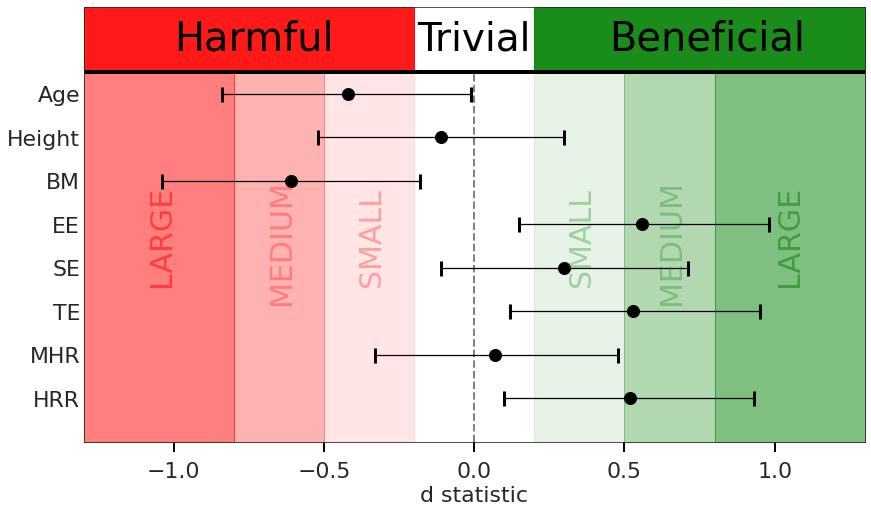

In [33]:
# Create the figure
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(14, 8))

n = 0

for index, i in df_dstat.iterrows():
   
    # Plot ES (d statistic)   
    y = [n]
    x = [i["d statistic"]]
    ax.plot(x, y, "o", color='black', markersize = 12)
    
    # Plot CI
    y = [n,n]
    x = [i["95%LCL"], i["95%UCL"]]
    ax.plot(x, y, "|-", markersize = 15, markeredgewidth=3, linewidth=1.25, color='black')
    
    n += 1

# Set axis
ax.set_xlim(xmin=-1.3, xmax=1.3)
ax.set_ylim(-1,8)
ax.set_yticks([])
ax.yaxis.set_ticks(np.arange(-1, 10))
ax.set_xlabel('d statistic')
ax.set_ylabel('')
#ax.set_yticklabels([''] + df_dstat['Variable'].tolist())
ax.set_yticks((0,1,2,3,4,5,6,7))
ax.set_yticklabels(('HRR','MHR','TE','SE','EE','BM','Height','Age'))

ax.tick_params(axis='x', which='both', length=10, width=2, direction='out', color='black', pad=10)
ax.tick_params(axis='y', which='both', length=0, width=0)

# Add lines around figure
sns.despine(left=False, right=False, bottom=False, top=False)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()): item.set_fontsize(22)

# Add lines to the figure
plt.vlines(x=0, ymin=-1, ymax=7.5, ls='--', linewidth=2, color='grey', zorder=2)
ax.axhline(7.5, color='black', linestyle='-', alpha=1, lw=4)

# Add background colours
ax.fill_between(x=[0.2,0.5], y1=[-1,-1], y2=[7.5,7.5], color='green', alpha=0.1, zorder=1)
ax.fill_between(x=[0.5,0.8], y1=[-1,-1], y2=[7.5,7.5], color='green', alpha=0.3, zorder=1)
ax.fill_between(x=[0.8,1.3], y1=[-1,-1], y2=[7.5,7.5], color='green', alpha=0.5, zorder=1)
ax.fill_between(x=[-0.2,-0.5], y1=[-1,-1], y2=[7.5,7.5], color='red', alpha=0.1, zorder=1)
ax.fill_between(x=[-0.5,-0.8], y1=[-1,-1], y2=[7.5,7.5], color='red', alpha=0.3, zorder=1)
ax.fill_between(x=[-0.8,-1.3], y1=[-1,-1], y2=[7.5,7.5], color='red', alpha=0.5, zorder=1)
ax.fill_between(x=[0.2,1.3], y1=[7.5,7.5], y2=[10,10], color='green', alpha=0.9, zorder=1)
ax.fill_between(x=[-1.3,-0.2], y1=[7.5,7.5], y2=[10,10], color='red', alpha=0.9, zorder=1)

# Add text on the figure
plt.annotate('Harmful', (-1, 8), fontsize=40, color='black')
plt.annotate('Trivial', (-0.19, 8), fontsize=39, color='black')
plt.annotate('Beneficial', (0.45, 8), fontsize=40, color='black')
plt.annotate('SMALL', (0.31, 2.7), fontsize=30, color='green', rotation='vertical', alpha=0.3)
plt.annotate('SMALL', (-0.39, 2.7), fontsize=30, color='red', rotation='vertical', alpha=0.3)
plt.annotate('MEDIUM', (0.61, 2.3), fontsize=30, color='green', rotation='vertical', alpha=0.3)
plt.annotate('MEDIUM', (-0.69, 2.3), fontsize=30, color='red', rotation='vertical', alpha=0.3)
plt.annotate('LARGE', (1, 2.7), fontsize=30, color='green', rotation='vertical', alpha=0.5)
plt.annotate('LARGE', (-1.09, 2.7), fontsize=30, color='red', rotation='vertical', alpha=0.5)

# Save
plt.show()
plt.savefig(fname='d_stat', format='jpeg', dpi=80, orientation='landscape', papertype='letter', transparent=True, bbox_inches='tight')
plt.close() # close the figure window

### d) Perform Welch ANOVA test to compare the three CR fitness zones

Next, we will split the applicants into colour coded groups ("zone") to account for total variability (± 5.6%) in their physical performance from one day to another.
- **Green zone**: applicants with $RelVO_2$ values > 45 (42.5 + 5.6%)
- **Red zone**: applicants with $RelVO_2$ values < 40 (42.5 - 5.6%)
- **Yellow zone**: applicants who falls between the red and green zones

Step 1: divide the dataset into three CR fitness zones

In [34]:
# Create the colour coded zones based on RelVO2 values
df['Zone'] = pd.cut(df['RelVO2'], bins=[0, 40, 45, 100], include_lowest = True, labels=['Red','Yellow','Green'])

In [35]:
# Calculate how many applicants in each zone
df.groupby('Zone')['Age'].agg(['count'])

count
Zone         
Red        21
Yellow     33
Green      67

In [36]:
# Calculate mean values for each zone
df.groupby('Zone')[columns_num].agg(['mean']).T

Zone                Red      Yellow       Green
Age    mean   28.285714   27.848485   24.985075
Height mean  179.433333  178.160606  178.550746
BM     mean   92.835714   85.833333   81.920896
EE     mean  108.571429  169.393939  235.075758
SE     mean  159.523810  169.757576  208.692308
TE     mean  268.095238  339.151515  442.187500
MHR    mean  195.666667  194.424242  195.253731
HRR    mean   34.476190   40.090909   42.340646
RelVO2 mean   37.163319   42.998572   51.176839

In [37]:
# Check for homogeneity among zones using Levene's test
lev_res = pd.DataFrame([])

for var in columns_num:
    
    # Perform the Levene's test
    lev_df = pg.homoscedasticity(df, dv=var, group='Zone')
    
    # Add Variable to the DF
    lev_df['Variable'] = var

    # Concat the empty DF with the Levene's test output
    lev_res = pd.concat([lev_res, lev_df])

# Display equality of variance output  
lev_res[['Variable','equal_var']]

Variable  equal_var
levene      Age       True
levene   Height       True
levene       BM       True
levene       EE      False
levene       SE      False
levene       TE      False
levene      MHR       True
levene      HRR       True
levene   RelVO2      False

Note: again since the assumption of equal variances is not met, we will use the Welch ANOVA test which does not assume equal variances and equal sample size.

Step 2: conduct ANOVA test to identify the differences between zones

(i) Conduct Welch ANOVA test

In [38]:
from pingouin import welch_anova, read_dataset

# Choose parameters that we want to perform an ANOVA test
columns_num = ['Age', 'Height', 'BM', 'EE', 'SE', 'TE', 'MHR', 'HRR', 'RelVO2']

# Create empty DF for ANOVA results
df_anova = pd.DataFrame([])

for var in columns_num[:-1]:

    # Perform the ANOVA
    anova = pg.welch_anova(dv=var, between='Zone', data=df)
    
    # Add variables to the ANOVA output
    anova['Variable'] = var

    # Append the ANOVA output to the empty DF
    df_anova = df_anova.append(anova)

# Display ANOVA p-values results
df_anova[['Variable','p-unc']]

Variable     p-unc
0      Age  0.027188
0   Height  0.834318
0       BM  0.002435
0       EE  0.000137
0       SE  0.340072
0       TE  0.003581
0      MHR  0.882089
0      HRR  0.011748

(ii) Conduct Games-Howell pairwise comparison to identify where the difference is. 

In [39]:
# Choose parameters that we want to perform a post-hoc test
columns_num = ['BM', 'EE','TE', 'HRR']

# Create empty DF for post-hoc results
df_gh = pd.DataFrame([])

for var in columns_num:

    # Perform Games-Howell post-hoc test
    post_hoc = pg.pairwise_gameshowell(dv=var, between='Zone', data=df)
    
    # Add variables to the post-hoc output
    post_hoc['Variable'] = var

    # Append the post-hoc output to the empty DF
    df_gh = df_gh.append(post_hoc)

# Display post-hoc results
df_gh[['Variable','A','B','mean(A)','mean(B)','diff','pval']]

Variable       A       B     mean(A)     mean(B)        diff      pval
0       BM     Red  Yellow   92.835714   85.833333    7.002381  0.119350
1       BM     Red   Green   92.835714   81.920896   10.914819  0.004657
2       BM  Yellow   Green   85.833333   81.920896    3.912438  0.153940
0       EE     Red  Yellow  108.571429  169.393939  -60.822511  0.094792
1       EE     Red   Green  108.571429  235.075758 -126.504329  0.001000
2       EE  Yellow   Green  169.393939  235.075758  -65.681818  0.085715
0       TE     Red  Yellow  268.095238  339.151515  -71.056277  0.438822
1       TE     Red   Green  268.095238  442.187500 -174.092262  0.003397
2       TE  Yellow   Green  339.151515  442.187500 -103.035985  0.115639
0      HRR     Red  Yellow   34.476190   40.090909   -5.614719  0.092577
1      HRR     Red   Green   34.476190   42.340646   -7.864455  0.009244
2      HRR  Yellow   Green   40.090909   42.340646   -2.249737  0.509438

Step 3: create boxplots to compare red and green zones for EE, TE, BM, and HRR

(i) Compare red and green zones for EE and TE

In [40]:
# Convert DF from wide to long to create boxplots
dfl = pd.melt(df, id_vars='Zone', value_vars=['TE', 'EE'])
dfl['Train_hrs'] = dfl['value']/60

In [41]:
# Calculate median values for each zone
df.groupby('Zone')[columns_num].agg(['median']).T

Zone          Red  Yellow  Green
BM  median   91.0    84.6   80.8
EE  median  120.0   135.0  230.0
TE  median  220.0   300.0  420.0
HRR median   35.0    40.0   43.0

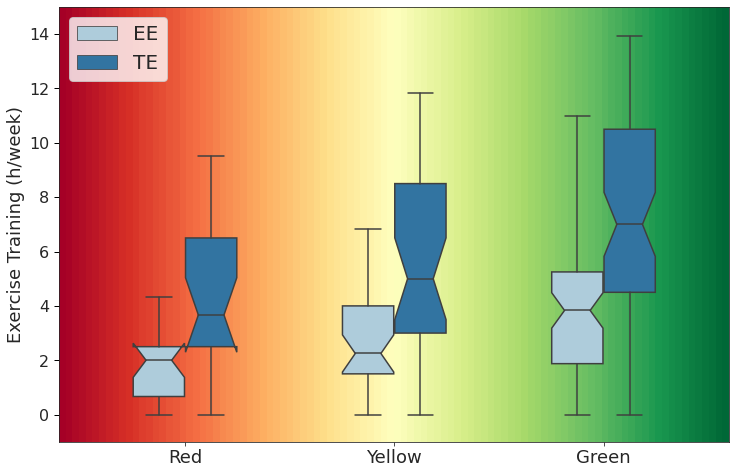

In [42]:
# Create notched boxplots
sns.set_style("ticks")
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111)

# Plot boxplot
ax = sns.boxplot(x='Zone', y='Train_hrs', hue='variable', data=dfl, hue_order=['EE','TE'], whis=[0,98],
                 notch=True, linewidth=1.5, showfliers=False, width=0.5, palette='Paired')
                 #medianprops=dict(linestyle='-', linewidth=5, color='black'))

# Set axis
ax.set_yticks(range(0,15,2))
plt.ylabel('Exercise Training (h/week)', fontsize=18)
plt.yticks(fontsize=16)
plt.xticks(fontsize=18)
plt.xlabel('')
ax.tick_params(axis='y', which='both', length=5, width=1, direction='out', color='black', pad=5)

# Add horizontal line
#ax.axhline(8, c="#01579B", linestyle='dashed', alpha=1, lw=2)

# Add background colours
gradient = np.linspace(start=0, stop=1, num=100).reshape(1, -1)
plt.imshow(gradient , extent=[-0.6, 2.6, -1, 15], aspect='auto', cmap='RdYlGn')

# Legend
plt.legend(fontsize=20)
plt.show()
plt.savefig(fname='zones_EE_TE', format='jpeg', dpi=80, orientation='landscape', papertype='letter', transparent=True, bbox_inches='tight')
plt.close()

(ii) Compare red and green zones for BM and HRR

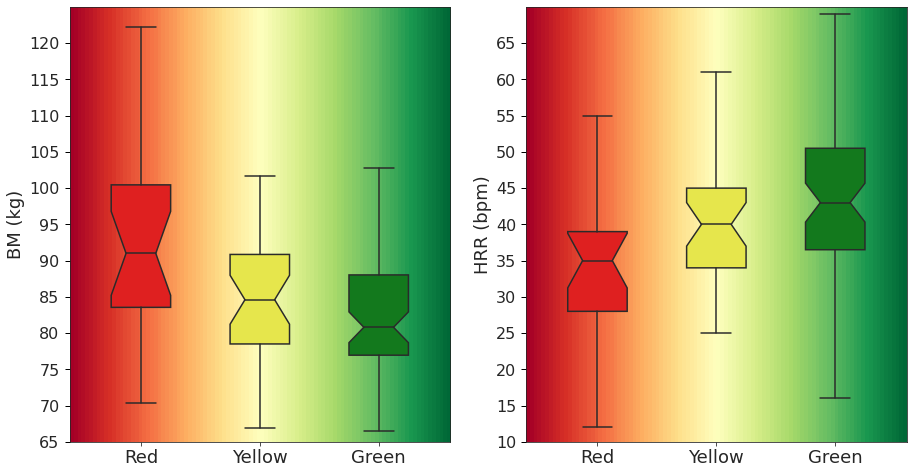

In [43]:
# Create notched boxplots
sns.set_style("ticks")
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(121)

# Create an array with the colours to use for the boxes
colours = ['red','#FFFF33','#028A0F']

# Create custom pallette
customPallette = sns.set_palette(sns.set_palette(colours))

''' Boxplot for BM'''

# Plot boxplot for BM
plt.subplot(121)
ax = sns.boxplot(x='Zone', y='BM', data=df, notch=True, linewidth=1.5, showfliers=False, width=0.5, palette=customPallette)
                 
# Set axis for BM
ax.set_yticks(range(65,125,5))
plt.ylabel('BM (kg)', fontsize=18)
plt.yticks(fontsize=16)
plt.xticks(fontsize=18)
plt.xlabel('')
ax.tick_params(axis='y', which='major', length=5, width=1, direction='out', color='black', pad=5)

# Add horizontal line
#ax.axhline(83, c="#01579B", linestyle='dashed', alpha=1, lw=2)

# Add background colours for BM
gradient = np.linspace(start=0, stop=1, num=100).reshape(1, -1)
plt.imshow(gradient , extent=[-0.6, 2.6, 65, 125], aspect='auto', cmap='RdYlGn')

''' Boxplot for HRR'''

# Plot boxplot for HRR
plt.subplot(122)
ax = sns.boxplot(x='Zone', y='HRR', data=df, notch=True, linewidth=1.5, showfliers=False, width=0.5, palette=customPallette)

# Set axis for HRR
ax.set_yticks(range(10,70,5))
plt.ylabel('HRR (bpm)', fontsize=18)
plt.yticks(fontsize=16)
plt.xticks(fontsize=18)
plt.xlabel('')
ax.tick_params(axis='y', which='major', length=5, width=1, direction='out', color='black', pad=5)

# Add horizontal line
#ax.axhline(46, c="#01579B", linestyle='dashed', alpha=1, lw=2)

# Add background colours for HRR
gradient = np.linspace(start=0, stop=1, num=100).reshape(1, -1)
plt.imshow(gradient , extent=[-0.6, 2.6, 10, 70], aspect='auto', cmap='RdYlGn')

# Save
plt.show()
plt.savefig(fname='zones_BM_HRR', format='jpeg', dpi=80, orientation='landscape', papertype='letter', transparent=True, bbox_inches='tight')
plt.close()

## 4) Linear Regression Models for $RelVO_2$

The previous sections dealt with understanding the differences in applicants in the successful and unsuccessful groups. Because the test pass/failure is based off of $RelVO_2$, it would be beneficial to applicants to know which parameters that they can observe or control correlate with a higher $RelVO_2$ scores.

### a) Checking the Linear Regression assumptions - Part I
    1) Check for a linear trend between the dependent and independent variables (features)
        ◦ using sns.regplot()
    2) Make sure that independent variables (features) are not highly correlated among themselves
        ◦ using correlation matrix (r <0.8)

**Check assumption #1: linearity**

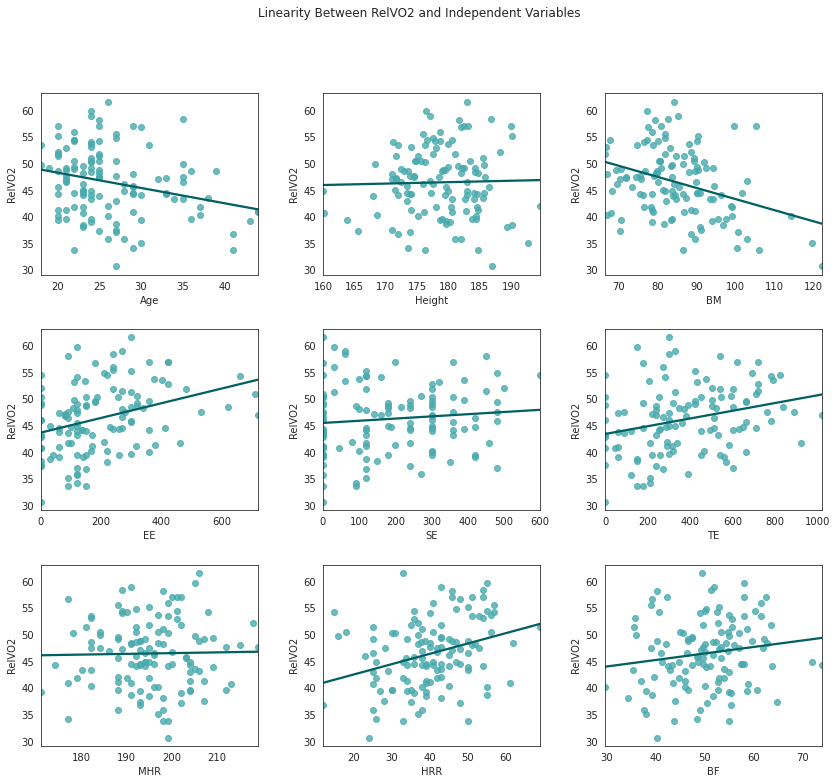

In [44]:
# Create a list of possible features for the prediction model
features = ['Age','Height','BM','EE','SE','TE','MHR','HRR', 'BF']

plt.subplots(figsize=(14, 12))
sns.set_style('white')
count=1

# Scatterplot for linearity
for var in features:
    
    plt.subplot(3,3,count)
    sns.regplot(x=var, y=df.RelVO2, data=df, ci=True, scatter_kws={'color':'#48aaad'}, line_kws={'color':'#016064'})
    count+=1
   
plt.suptitle('Linearity Between RelVO2 and Independent Variables')
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show() 

Note: it is somewhat difficult to visually see which variables have a linear relationships with the $RelVO_2$ parameter. However, right away we can identify a few features that show no signs of linearity, due to being essentially homogeneous clouds with minimal slope (Height, SE, MHR). We can exclude these features going forward because they do not meet one of the assumptions for linear regression. 



**Check assumption #2: no multicollinearity among independent variables (features)**

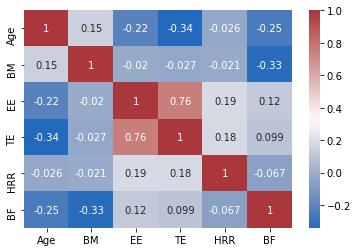

In [45]:
# Create a new df with features showing linearity with the DV, for the purpose of evaluating the correlation between them
features = df[['Age','BM','EE','TE','HRR','BF']] 

# Restore all RC params to original settings
sns.reset_orig() 
plt.figure(figsize=(6,4))

# Show correlation coefficients to check for multicollinearity among features
sns.heatmap(features.corr(), annot=True, cmap=sns.cm.vlag)
plt.show()

The only pair of features which approach the r < 0.8 threshold for collinearity is TE with EE. Models which use these features together have a chance of multicollinearity and should be scrutinized closely for applicability.

### b) Single linear regression models

To see which variables may provide good linear relationships with $RelVO_2$, we can quickly run an OLS regression model for the features above and see what the *p* values will be for those models. Only statistically significant coefficients would need to be investigated further

In [46]:
# Create an empty DF for single linear regression results
ols_results = pd.DataFrame(columns = ['Parameter', 'Coefficient', 'P-value','R-squared'])

# Perform a single linear regression between RelVO2 and all features
for parameter in features:
    command = 'RelVO2 ~ ' + parameter
    model = sm.ols(command, data = df).fit()
    intercept, slope = model.params
    p_intercept, p_slope = model.pvalues
    
    # Append results from single linear regression to the empty DF
    values = {'Parameter':parameter, 'Coefficient':slope, 'P-value':p_slope,'R-squared':model.rsquared}
    ols_results = ols_results.append(values, ignore_index=True)

# Display single linear regression results
ols_results.head(7)

Parameter  Coefficient   P-value  R-squared
0       Age    -0.287078  0.003851   0.068057
1        BM    -0.208224  0.000102   0.119572
2        EE     0.013785  0.000209   0.110435
3        TE     0.007276  0.002516   0.075991
4       HRR     0.194187  0.000391   0.100673
5        BF     0.122120  0.094444   0.023722

**Note:**
- detailed calculations and exploratory plotting were done on all possible features first to have an idea of how each feature is related to RelVO2. However, for clarity they were left out of this notebook. All models showed linearity and normality of residuals, and no significance in change to the models after removing influential points.

- since no single linear regression model explained more than ~11% of the variability on the RelVO2 parameter on it's own, multiple linear regression models were attempted next.


### c) Multiple Linear Regression Models

As mentioned, the next step in modelling or predicting $RelVO_2$ outcomes is to build a multiple linear regression model. The important consideration here is that some of the features are related and if added into the model together would introduce multicollinearity. 


In [47]:
df[['Age','BM','EE','TE','HRR','BF']].corr()

Age        BM        EE        TE       HRR        BF
Age  1.000000  0.150854 -0.216673 -0.340326 -0.026255 -0.253150
BM   0.150854  1.000000 -0.020238 -0.027395 -0.020607 -0.329564
EE  -0.216673 -0.020238  1.000000  0.758907  0.192725  0.120650
TE  -0.340326 -0.027395  0.758907  1.000000  0.184970  0.098546
HRR -0.026255 -0.020607  0.192725  0.184970  1.000000 -0.067243
BF  -0.253150 -0.329564  0.120650  0.098546 -0.067243  1.000000

Of the chosen features, the only pair of concern are TE with EE. Because TE is based on EE + SE, this makes sense. Although the correlation coefficient is not greater than 0.8, any model with these two features in it is at risk of having increase colinearity.

There are different ways to check multilinear models (backward elimination/forward selection), however in this case due to the relatively small number of features and data size, we can do a brute force method of try all combinations. 

What we are looking for is statistical significance in all the regression coefficient (*p* < 0.05). There are different ways of comparing models, though $R^2$ gives a measure of how the model fits the data, it is not neccesarily the best model that will predict new data. Instead the Akaike Information Criterion (AIC)  and Bayesian Information Criterion (BIC) can be used. Both measures are penalized-likelihood criteria, meaning that they balance the likelihood of fit with the number of parameters in the model. For these parameters, lower values are better.

Step 1: Find permutations of multiple linear regression (MLR) models to evaluate

In [48]:
# First, let's split the dataset into train (75%) dataset and test (25%) dataset
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.30)

In [49]:
import itertools as it

# Determine features we want to use for the model
features = ['Age','BM','EE','TE','HRR','BF']

# Create empty DF for good models
reg_results = pd.DataFrame(columns = ['Model', 'Adj. R-squared', 'AIC', 'BIC' ])

In [50]:
# Create empty list for permutations
permutations= []

for i in range(1,6):
    items = list(it.combinations(features, i))
    
    for item in items:
        command = 'RelVO2 ~ '
        for j in range(len(item)):
            if(j>0):command += ' + '
            command += str(item[j])

        # Append all possible combinations to empty list    
        permutations.append(command)

# Display a few examples in the list        
permutations[:10]

['RelVO2 ~ Age',
 'RelVO2 ~ BM',
 'RelVO2 ~ EE',
 'RelVO2 ~ TE',
 'RelVO2 ~ HRR',
 'RelVO2 ~ BF',
 'RelVO2 ~ Age + BM',
 'RelVO2 ~ Age + EE',
 'RelVO2 ~ Age + TE',
 'RelVO2 ~ Age + HRR']

Step 2: Loop through all the permutations and identify good models if the *p*-values <0.05 for all features.

    Note: we also saw that individual feature models can have R-squared values close to 0.1, so we want a multi-features
    model that is better than that. We will also filter out adj. R-squared values of < 0.1

In [51]:
for k in permutations:
    
    # Start by saying the model is good
    ok = 1
    
    # Build models for all possible combinations of features using train dataset
    model = sm.ols(k, data=train).fit()

    # Change to a bad model if any p values > 0.05
    for p in model.pvalues.values:
        if p > 0.05:
            ok = 0

      # Keep model only if it's a good model (ok=1) and its adjR2 > 0.1        
    if (ok==1 and model.rsquared_adj > 0.1):
          results = {'Model':k, 'Adj. R-squared': round(model.rsquared_adj,3), 'AIC':round(model.aic,1), 'BIC':round(model.bic,1) }
       
      # Append good models to empty DF created earlier
          reg_results = reg_results.append(results, ignore_index=True)

# Display which models end up with good values
reg_results   

Model  Adj. R-squared    AIC    BIC
0                    RelVO2 ~ BM           0.148  531.8  536.7
1                    RelVO2 ~ EE           0.104  529.1  533.9
2              RelVO2 ~ Age + BM           0.204  527.0  534.3
3              RelVO2 ~ Age + EE           0.145  526.1  533.4
4             RelVO2 ~ Age + HRR           0.161  531.4  538.7
5               RelVO2 ~ BM + EE           0.237  516.7  524.0
6               RelVO2 ~ BM + TE           0.203  504.6  511.8
7              RelVO2 ~ BM + HRR           0.223  525.0  532.3
8              RelVO2 ~ EE + HRR           0.183  522.4  529.7
9              RelVO2 ~ TE + HRR           0.131  511.6  518.8
10             RelVO2 ~ HRR + BF           0.139  527.5  534.7
11        RelVO2 ~ Age + BM + EE           0.267  514.4  524.1
12       RelVO2 ~ Age + BM + HRR           0.285  519.0  528.7
13       RelVO2 ~ Age + EE + HRR           0.235  517.9  527.6
14       RelVO2 ~ Age + HRR + BF           0.184  523.9  533.6
15        RelVO2 ~ BM + EE + HRR           0.310  509.3  519.0
16        RelVO2 ~ BM + TE + HRR           0.267  498.7  508.3
17        RelVO2 ~ EE + HRR + BF           0.223  513.2  522.8
18  RelVO2 ~ Age + BM + EE + HRR           0.350  505.4  517.5

The last two models have the best adj. R-squared values of all the models, and have the best AIC and BIC scores as well. They both contain BM and HRR, the difference being either using EE or TE. Luckily no model used both, so we don't have to worry about the collinearity that was mentioned before between these two features.

We can investigate them in more details before looking at ways to choose which model is more useful. We will refer to these as model "A" and model "B" for the next few sections.

Step 3: (i) Build MLR models using OLS

In [52]:
# Build Model A with train dataset 
modelA_train = sm.ols("RelVO2 ~ BM + EE + HRR", data=train).fit()
print(modelA_train.summary())

                            OLS Regression Results                            
Dep. Variable:                 RelVO2   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     13.31
Date:                Mon, 09 Aug 2021   Prob (F-statistic):           4.09e-07
Time:                        10:26:22   Log-Likelihood:                -250.64
No. Observations:                  83   AIC:                             509.3
Df Residuals:                      79   BIC:                             519.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     54.1783      4.917     11.019      0.0

In [53]:
# Build Model B with train dataset 
modelB_train = sm.ols("RelVO2 ~ BM + TE + HRR", data=train).fit()
print(modelB_train.summary())

                            OLS Regression Results                            
Dep. Variable:                 RelVO2   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     10.72
Date:                Mon, 09 Aug 2021   Prob (F-statistic):           5.75e-06
Time:                        10:26:22   Log-Likelihood:                -245.37
No. Observations:                  81   AIC:                             498.7
Df Residuals:                      77   BIC:                             508.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     54.4703      4.989     10.919      0.0

### d) Models evaluation using test datasets

It is good practice to use train/test dataset to determining which model might have better predictive power. We can try random combinations of the data sets to fit models, and use these models to predict $RelVO_2$ with the test sets. 

Step 1: Determine the predictive power for each model using test dataset

In [59]:
from sklearn.model_selection import train_test_split
from statsmodels.tools.eval_measures import rmse

# Create empty DF with the results summary
model_results = pd.DataFrame(columns = ['A_success', 'A_MAE', 'A_RMSE','A_NRMSE','B_success', 'B_MAE','B_RMSE', 'B_NRMSE'])

for i in range(100):
    
    # Split the dataset into train (75%) and test (25%) smaller df
    train, test = train_test_split(df, test_size=0.25)
    
    #Run the fit for Model A using the train set    
    modelA = sm.ols("RelVO2 ~ BM + EE + HRR", data=train).fit()
    
    # Get the predicted RelVO2 values using the test set
    '''RelVO2_pred = B0 + B1*BM + B2*EE + B3*HRR'''
    test['ModelA_predVO2'] = (modelA.params['Intercept'] + modelA.params['BM']*test['BM']
                             + modelA.params['HRR']*test['HRR'] + modelA.params['EE']*test['EE'])
    
    # Determine whether the test set would pass or fail the applicant based on model A (return T/F)
    test['ModelA_Pass'] = test.ModelA_predVO2 >= 42.5
    
    # Calculate the success rate (%) of model A predictions
    modelA_success = (test['Pass'] == test['ModelA_Pass']).mean()
    
    # Calculate the mean absolute error (difference) in ml/kg/min between predicted and actual RelVO2 values 
    modelA_VO2Diff = np.mean(abs(test.RelVO2 - test.ModelA_predVO2))
    #modelA_VO2Diff = mean_absolute_error(test.RelVO2, test.ModelA_RelVO2)

    # Calculate the root mean square error (RMSE) in ml/kg/min between actual and predicted RelVO2 values 
    modelA_rmse = rmse(test.ModelA_predVO2, test.RelVO2)
   
    # Normalize by the mean of actual RelVO2
    modelA_nrmse = modelA_rmse / test.RelVO2.mean() * 100
       
    

    '''Doing the same for model B'''

    # Calculate the mean absolute difference between predicted and real RelVO2 values
    modelB = sm.ols("RelVO2 ~ BM + TE + HRR", data=train).fit()
    
    # Get the predicted RelVO2 values using the test set
    '''RelVO2_pred = B0 + B1*BM + B2*TE + B3*HRR'''
    test['ModelB_predVO2'] = (modelB.params['Intercept'] + modelB.params['BM']*test['BM']
                             + modelB.params['HRR']*test['HRR'] + modelB.params['TE']*test['TE'])

    # Determine whether the test set would pass or fail the applicant based on model B (return T/F)
    test['ModelB_Pass'] = test.ModelB_predVO2 >= 42.5
    
    # Calculate the success rate (%) of model B predictions 
    modelB_success = (test['Pass'] == test['ModelB_Pass']).mean()
    
    # Calculate the mean absolute difference (in ml/kg/min) between predicted and real RelVO2 values
    modelB_VO2Diff = np.mean(abs(test.RelVO2 - test.ModelB_predVO2))
    
    # Calculate the root mean square error (RMSE) in ml/kg/min between actual and predicted RelVO2 values 
    modelB_rmse = rmse(test.ModelB_predVO2, test.RelVO2)
    #print('RMSE = %f' %modelA_rmse)

    # Normalize by the mean of actual RelVO2
    modelB_nrmse = modelB_rmse / test.RelVO2.mean() * 100
    #print('NRMSE = {:.1%}'.format(modelA_nrmse)) # turn it into a %
    
    '''Append the results in the empty summary DF'''

    results = {'A_success':modelA_success*100, 'A_MAE':modelA_VO2Diff, 'A_RMSE':modelA_rmse, 'A_NRMSE':modelA_nrmse,
               'B_success':modelB_success*100, 'B_MAE':modelB_VO2Diff, 'B_RMSE':modelB_rmse, 'B_NRMSE':modelB_nrmse}
    
    model_results = model_results.append(results, ignore_index=True)

# Display results summary
model_results.agg(['mean','std','min','max']) 

A_success     A_MAE    A_RMSE    A_NRMSE  B_success     B_MAE    B_RMSE  \
mean  73.758621  4.435808  5.561018  11.996862  74.758621  4.553579  5.667494   
std    7.267869  0.565852  0.610006   1.289650   7.447192  0.581612  0.668535   
min   55.172414  3.285299  4.200101   8.813739  55.172414  3.362023  4.129935   
max   93.103448  5.751665  6.882106  15.186013  89.655172  5.856034  7.063652   

        B_NRMSE  
mean  12.227082  
std    1.421258  
min    8.824412  
max   15.268518

After running one hundred trials, seperating the data into 75:25 train:test groups, we can see that the prediction for both models is pretty good. On average, a model will predict the $RelVO_2$ value enough to correctly predict success or failure on the fitness test for 72% of the applicants. Both models have similar average deviations from the true $RelVO_2$ values as well.


Step 2: Plot the success rate from each model.

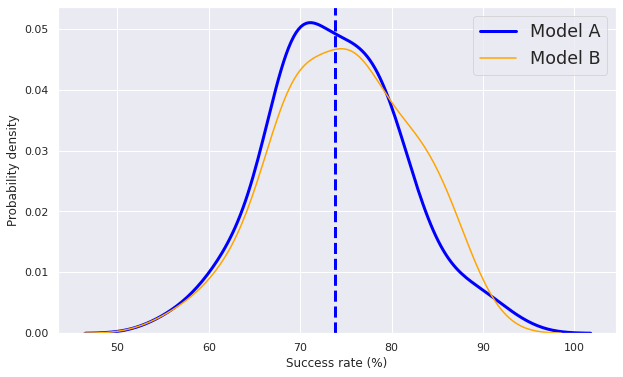

In [60]:
# Setup graph
plt.figure(figsize=(10,6))
sns.set(style="darkgrid")

# Plot both distibutions on the same figure
sns.kdeplot(x=model_results['A_success'], color='blue', shade=False, label='Model A', linewidth=3, linestyle='-') 
sns.kdeplot(x=model_results['B_success'], color='orange', shade=False, label='Model B')  

# Axis
plt.xlabel('Success rate (%)')
plt.ylabel('Probability density')

# Change size of legend
sns.set_context('paper', font_scale = 2.0)

# Draw a line at mean success rate for Model A
plt.axvline(model_results['A_success'].mean(), c='blue', linestyle='dashed', alpha=1, linewidth=3)

plt.legend()
plt.show()

Step 3: Examine $R^2$, AIC, and BIC values for each model.

In [61]:
# Looking back at the AIC and BIC values for the best 2 models:
print('R2 model A:', round(modelA_train.rsquared_adj, 2))
print('R2 model B:', round(modelB_train.rsquared_adj, 2))
print('AIC model A:', round(modelA_train.aic))
print('AIC model B:', round(modelB_train.aic))
print('BIC model A:', round(modelA_train.bic))
print('BIC model B:', round(modelB_train.bic))

R2 model A: 0.31
R2 model B: 0.27
AIC model A: 509
AIC model B: 499
BIC model A: 519
BIC model B: 508


Although Model B has a lower $R^2$ than Model A, it has lower AIC & BIC values. The magnitude of the difference in AIC between the two models is < 10 and as a result either models could be used. Therefore, this comes down to the ultimate goal of the model, which would be to help applicants estimate their $RelVO_2$ scores based on some measureable metrics (BM, HRR, EE/TE).

Ideally, an applicant could measure their body weight, heart rate recovery after a workout, as well as the time spend excercising to predict their $RelVO_2$, and thus whether they would pass the test.

Given that strength and power excercise (SE) was found to be non-significant, it may be misleading to use a model with TE in it, with no requirement on what proportion of that excercise is endurance based. In other words, an applicant could keep increasing SE (and simultaneously TE), and would expect their $RelVO_2$ values to increase. Because of this scenario, EE might be a more specific criteria that would have more usefullness when actually used by applicants.

**Final decision:**
- Going forward, we will use Model A (RelVO2 ~ BM + EE + HRR) and check the other MLR model assumptions.




### e) Checking the multiple linear regression assumptions - Part II
    2) re-check for multicollinearity
        ◦ calculate VIF factor
    3) constant variance of residuals
        ◦ calculate and plot residuals
    4) normal distribution of residuals
        ◦ using stats.probplot()
        ◦ check for skewness and kurtosis of residuals
    5) no autocorrelation
        ◦ Durbin Watson statistic (btw 1.2 and 2.8)

**Re-check assumption #2: no multicollinearity**

In [62]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create VIF dataframe
df_vif = pd.DataFrame()
df_vif['Features'] = ['Intercept','BM','EE','HRR']

# Run OLS regression of the full dataset again
modelA_train = sm.ols("RelVO2 ~ BM + EE + HRR", data=train).fit()
variables = modelA_train.model.exog

# Calculate VIF factor
df_vif['VIF factor modelA'] = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
df_vif

Features  VIF factor modelA
0  Intercept          81.310516
1         BM           1.004489
2         EE           1.026800
3        HRR           1.023037

- The Variance Inflation Factor (VIF) measures for how much multicollinearity exists in a regression model. Essentially, it measures for how much regression coefficients are affected by other independent variables in the model. Higher values of Variance Inflation Factor (VIF) are associated with multicollinearity. 
- In other words, it quantifies the severity of multicollinearity in an ordinary least squares regression analysis. It provides an index that measures how much the variance of an estimated regression coefficient is increased because of collinearity. https://en.wikipedia.org/wiki/Variance_inflation_factor
- The generally accepted cutoff for VIF is 10, with higher values denoting levels of multicollinearity that could negatively impact the regression model. However, some authors suggest a more conservative level of 2.5 or above. https://en.wikipedia.org/wiki/Variance_inflation_factor
- Model A does not show multicollinearity because the VIF factor is less than the conservative cutoff of 2.5 for all features.

**Check assumption #3: constant variance of residuals**

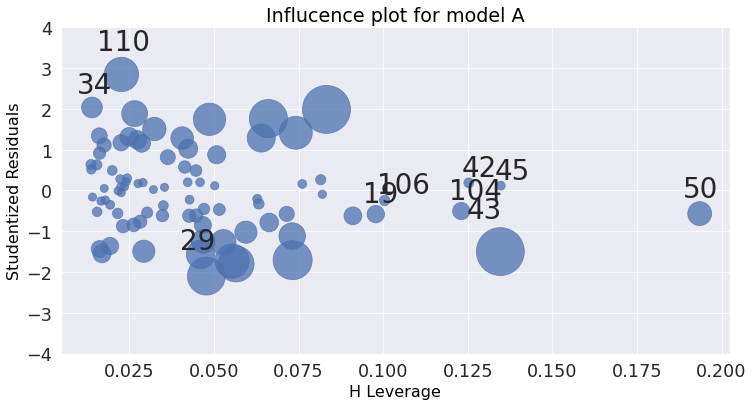

Maximum leverage point in this model is 0.194000 which is higher than 3*k/n (0.10).
Maximum residual point in this model is 2.729749 which is <3.
Minimum residual point in this model is -2.058640 which is >-3.


In [63]:
# Plot influcence plot
fig, ax = plt.subplots(figsize=(12,6))
fig = influence_plot(results=modelA_train, ax=ax, criterion='Cooks')
plt.ylim(-4,4)
plt.title('Influcence plot for model A')
plt.show()

# Calculate leverage
k = 5
n = 120
influence = modelA_train.get_influence()
leverage = influence.hat_matrix_diag
print('Maximum leverage point in this model is %f which is higher than 3*k/n (0.10).' %round(leverage.max(), 3))

# Calculate residuals
residuals = influence.resid_studentized_internal
print('Maximum residual point in this model is %f which is <3.' %residuals.max())
print('Minimum residual point in this model is %f which is >-3.' %residuals.min())

- Note: points at index #50 and 91 has high leverage and should try to re-fit the model without this particular point.


- Note: also that influcencial points change every time and new train/test dataset is created. For this reason, I'll disabled the cells so that the notebook runs until the end every time.

In [64]:
# Locate the point with high leverage (note that they change every time a new random train dataset is created that's why it blocks)
rain2 = train[['Age','BM','EE','TE','HRR','BF','RelVO2']]
#train2.loc[[50,91]]

In [65]:
# Create a new df without the influential points to see if they affect the model
#train_no_inf = train2.drop(labels=[50,91], axis=0)

In [66]:
# Recreate model A without the influential points using train dataset
#modelA_train_no_inf = sm.ols("RelVO2 ~ BM + EE + HRR", data=train_no_inf).fit()
#print(modelA_train_no_inf.summary())

In [67]:
'''
# Calculate the difference in coefficients before and after removal influential points

slope_BM = modelA_train.params[1]# Intercept [0], BM [1], EE [2], HRR [3] 
slope_EE = modelA_train.params[2]
slope_HRR = modelA_train.params[3]

slope_BM_2 = modelA_train_no_inf.params[1]
slope_EE_2 = modelA_train_no_inf.params[2]
slope_HRR_2 = modelA_train_no_inf.params[3]

diff_BM = abs(slope_BM - slope_BM_2)
diff_EE = abs(slope_EE - slope_EE_2)
diff_HRR = abs(slope_HRR - slope_HRR_2)

print('Difference in BM coef is :', diff_BM)
print('Difference in EE coef is :', diff_EE)
print('Difference in HRR coef is :', diff_HRR)'''

"\n# Calculate the difference in coefficients before and after removal influential points\n\nslope_BM = modelA_train.params[1]# Intercept [0], BM [1], EE [2], HRR [3] \nslope_EE = modelA_train.params[2]\nslope_HRR = modelA_train.params[3]\n\nslope_BM_2 = modelA_train_no_inf.params[1]\nslope_EE_2 = modelA_train_no_inf.params[2]\nslope_HRR_2 = modelA_train_no_inf.params[3]\n\ndiff_BM = abs(slope_BM - slope_BM_2)\ndiff_EE = abs(slope_EE - slope_EE_2)\ndiff_HRR = abs(slope_HRR - slope_HRR_2)\n\nprint('Difference in BM coef is :', diff_BM)\nprint('Difference in EE coef is :', diff_EE)\nprint('Difference in HRR coef is :', diff_HRR)"

In [68]:
'''# Calculate SE pooled
SE_BM_1 = 0.054
SE_EE_1 = 0.004
SE_HRR_1 = 0.064 

SE_BM_2 = 0.068
SE_EE_2 = 0.005
SE_HRR_2 = 0.064  

SE_BM = sqrt(SE_BM_1**2 + SE_BM_2**2)
SE_EE = sqrt(SE_EE_1**2 + SE_EE_2**2)
SE_HRR = sqrt(SE_HRR_1**2 + SE_HRR_2**2)

print('SE pooled for BM is:', SE_BM)
print('SE pooled for EE is:', SE_EE)
print('SE pooled for HRR is:', SE_HRR)'''

"# Calculate SE pooled\nSE_BM_1 = 0.054\nSE_EE_1 = 0.004\nSE_HRR_1 = 0.064 \n\nSE_BM_2 = 0.068\nSE_EE_2 = 0.005\nSE_HRR_2 = 0.064  \n\nSE_BM = sqrt(SE_BM_1**2 + SE_BM_2**2)\nSE_EE = sqrt(SE_EE_1**2 + SE_EE_2**2)\nSE_HRR = sqrt(SE_HRR_1**2 + SE_HRR_2**2)\n\nprint('SE pooled for BM is:', SE_BM)\nprint('SE pooled for EE is:', SE_EE)\nprint('SE pooled for HRR is:', SE_HRR)"

In [69]:
'''# Calculate p-value (two-tailed) with mean_H0 (loc) set at 0 (no difference in coefficients) and mean_Ha = diff_(i)
pval_BM = 2*(1-stats.norm.cdf(x=diff_BM, loc=0, scale=SE_BM))
pval_EE = 2*(1-stats.norm.cdf(x=diff_EE, loc=0, scale=SE_EE))
pval_HRR = 2*(1-stats.norm.cdf(x=diff_HRR, loc=0, scale=SE_HRR))

print('p-value for BM = ', pval_BM)
print('p-value for EE = ', pval_EE)
print('p-value for HRR = ', pval_HRR)'''

"# Calculate p-value (two-tailed) with mean_H0 (loc) set at 0 (no difference in coefficients) and mean_Ha = diff_(i)\npval_BM = 2*(1-stats.norm.cdf(x=diff_BM, loc=0, scale=SE_BM))\npval_EE = 2*(1-stats.norm.cdf(x=diff_EE, loc=0, scale=SE_EE))\npval_HRR = 2*(1-stats.norm.cdf(x=diff_HRR, loc=0, scale=SE_HRR))\n\nprint('p-value for BM = ', pval_BM)\nprint('p-value for EE = ', pval_EE)\nprint('p-value for HRR = ', pval_HRR)"

We can see that removing the influential points does not make significant difference in coefficents to the model, thus all observations will remain in the train dataset.

In [70]:
# Calculate the residuals of RelVO2 using test dataset

# Predict RelVO2 using model A with test data
test['y_pred'] = modelA_train.predict(test)

# Calculate the mean of the residuals (actual - predicted) using train data
test['Residuals'] = test.RelVO2 - test.y_pred

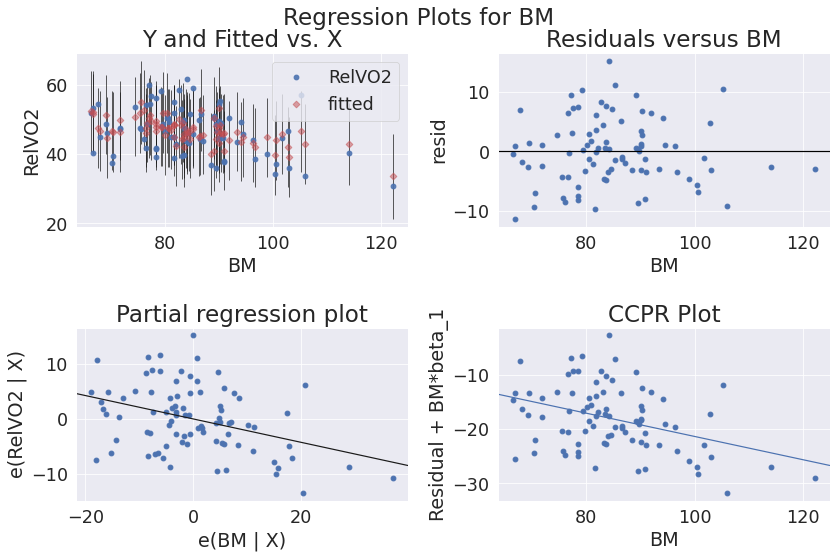

In [71]:
# Plot the residuals for BM
figure = plt.figure(figsize=(12,8))
fig = plot_regress_exog(results=modelA_train, exog_idx='BM', fig=figure)

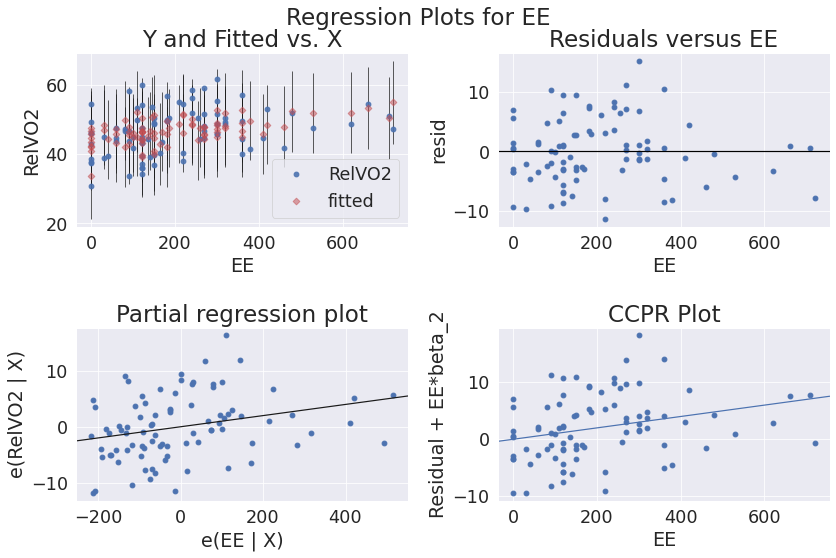

In [72]:
# Plot the residuals for EE
figure = plt.figure(figsize=(12,8))
fig = plot_regress_exog(results=modelA_train, exog_idx='EE', fig=figure)

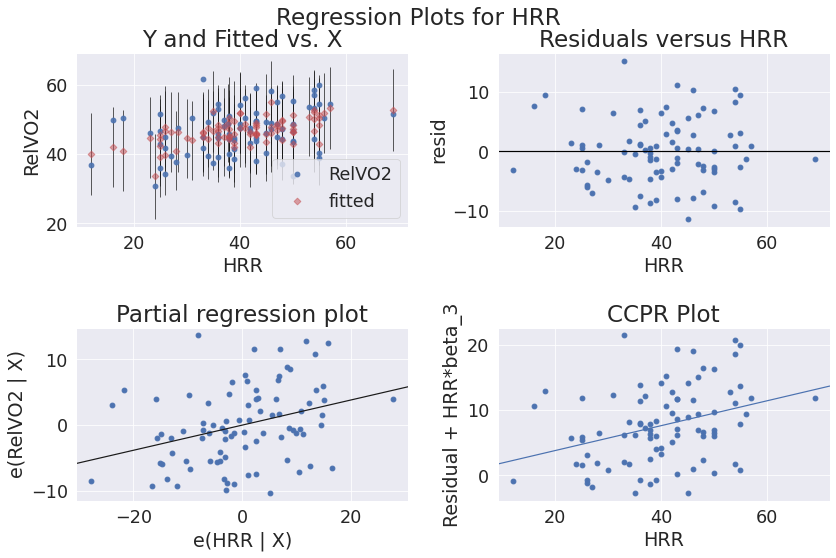

In [73]:
# Plot the residuals for HRR
figure = plt.figure(figsize=(12,8))
fig = plot_regress_exog(results=modelA_train, exog_idx='HRR', fig=figure)

In [74]:
# Calculate the average in residuals (should be close to 0) 
print('The mean of the residuals for RelVO2 using model A is', round(test.Residuals.mean(),1))

The mean of the residuals for RelVO2 using model A is -1.5


Note:
- For all features, the distribution of residuals look constant and centered around 0, therefore does not violate the assumption.
- The mean of the residuals for $RelVO_2$ using the train dataset is 0.6 which is really close to zero (note that this values changes everytime a new randome test dataset is generated).

**Check assumption #4: normal distribution of residuals**

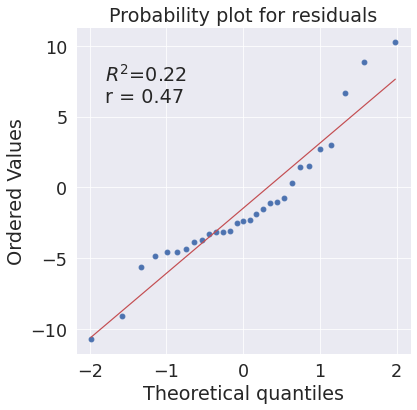

In [75]:
# Create normal probability plot of residuals using test dataset
test = test.dropna()
plt.figure(figsize=(6,6))

stats.probplot(x=test.Residuals, dist='norm', plot=plt)
r2 = r2_score(y_true=test.RelVO2, y_pred=test.y_pred)
plt.annotate("$R^2$={:.2f} \nr = {:.2f}".format(r2,sqrt(r2)), (-1.8,6))
plt.title('Probability plot for residuals')
plt.show()

In [76]:
# Check for skewness and kurtosis of residuals
test.agg(['skew', 'kurtosis'])[['Residuals']].transpose()

skew  kurtosis
Residuals  0.79382  1.262213

- The normal distribution has a skewness of 0 and a kurtosis of 3.
- Since the skewness is 0.45 and falls between -0.5 and 0.5, the distribution of the residuals is approximately symmetric. The kurtosis is -0.19, also within acceptable range to confirm the assumption of normal distribution of residuals.

**Check assumption #5: no autocorrelation**

- The value from the Durbin-Watson test is at 1.677 which is between 1.2 and 2.8 suggesting no auto-correlation between variables. As a result, this assumption is also met.